In [2]:
# Backtesting a Trading Strategy using Object Oriented Programming [OOP]
# https://www.youtube.com/watch?v=yTupVd6D9m8

In [1]:
import yfinance as yf
# data handling
import pandas as pd
# calculation purporses
import numpy as np
# technical indictor
import ta
# for visualization
import matplotlib.pyplot as plt

In [39]:
class Backtest:
    def __init__(self, symbol):
        self.symbol = symbol
        self.df = yf.download(self.symbol, start='2019-01-01')
        
        if self.df.empty:
            print("No Data Pulled")
        else:
            self.calc_indicators()
            self.generate_signals()
            self.loop_it()
            self.profit = self.calc_profit()
            self.max_dd = self.profit.min()
            self.cumul_profit = (self.profit + 1).prod() - 1
            
    def calc_indicators(self):
        self.df['ma_20'] = self.df.Close.rolling(20).mean()
        # rolling standard deviation
        self.df['vol'] = self.df.Close.rolling(20).std()
        self.df['upper_bb'] = self.df.ma_20 + (2*self.df.vol)
        self.df['lower_bb'] = self.df.ma_20 - (2*self.df.vol)
        self.df['rsi'] = ta.momentum.rsi(self.df.Close, window=6)
        self.df.dropna(inplace=True)
        
    def generate_signals(self):
        conditions = [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),
              (self.df.rsi > 70) & (self.df.Close < self.df.upper_bb)]
        choices = ['Buy', 'Sell']
        self.df['signal'] = np.select(conditions, choices)
        # close row before == shifted_close --> makes it more convenient to access signal when Backtester is iterating
        self.df['shifted_Close'] = self.df.Close.shift()
        self.df.dropna(inplace=True)
        
    def loop_it(self):
        position = False
        buydates, selldates = [], []
        
        for index, row in self.df.iterrows():
            if not position and row['signal'] == 'Buy':
                buydates.append(index)
                position = True
            if position:
                if row['signal'] == 'Sell': # or row.shifted_Close < 0.95 * buyprices[-1]:
                    selldates.append(index)
                    position = False
                    
        self.buy_arr = self.df.loc[buydates].Open
        self.sell_arr = self.df.loc[selldates].Open

    def calc_profit(self):
        # gets rid of last buy order if it hasn't triggered and sold yet
        if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
            self.buy_arr = self.buy_arr[:-1]
        
        return (self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values
    
    def chart(self):
        plt.figure(figsize=(20,10))
        plt.plot(self.df.Close)
        plt.scatter(self.buy_arr.index, self.buy_arr.values, marker="^", c='g')
        plt.scatter(self.sell_arr.index, self.sell_arr.values, marker="v", c='r')        

In [40]:
instance = Backtest('AAPL')
instance.df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma_20,vol,upper_bb,lower_bb,rsi,signal,shifted_Close
Date,,,,,,,,,,,,,
2019-01-31,41.527500,42.250000,41.139999,41.610001,40.227592,162958400,38.494625,1.352161,41.198947,35.790303,76.744352,0,41.312500
2019-02-01,41.740002,42.244999,41.482498,41.630001,40.246914,130672400,38.798750,1.338374,41.475498,36.122002,76.863160,0,41.610001
2019-02-04,41.852501,42.915001,41.820000,42.812500,41.390133,125982000,39.086125,1.547260,42.180645,35.991605,83.018335,0,41.630001
2019-02-05,43.215000,43.770000,43.087502,43.544998,42.098297,144406400,39.414250,1.759026,42.932301,35.896199,85.822066,0,42.812500
2019-02-06,43.662498,43.892502,43.212502,43.560001,42.112801,112958400,39.707875,1.936771,43.581416,35.834334,85.879368,Sell,43.544998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07,154.820007,156.669998,153.610001,155.960007,155.960007,87449600,165.701002,6.886283,179.473569,151.928435,28.391564,0,154.529999
2022-09-08,154.639999,156.360001,152.679993,154.460007,154.460007,84923800,164.962002,7.268932,179.499866,150.424138,24.423224,0,155.960007
2022-09-09,155.470001,157.820007,154.750000,157.369995,157.369995,68028800,164.406001,7.408811,179.223623,149.588379,42.977599,0,154.460007


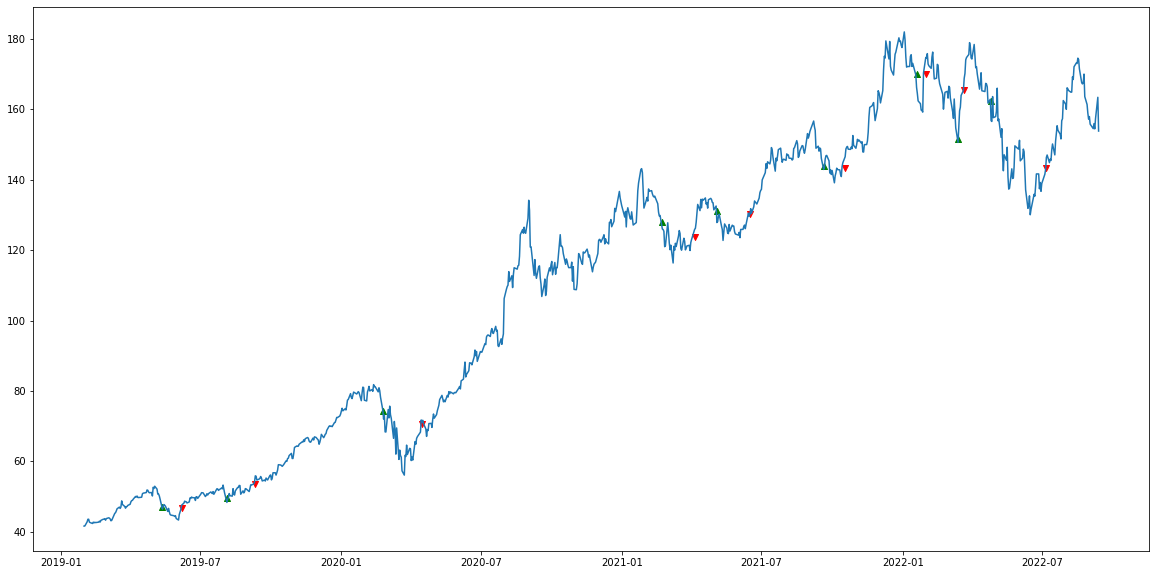

In [42]:
instance.chart()